In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from joblib import parallel_config
from sklearn.model_selection import GridSearchCV
from torch_geometric.data import Dataset

from mqt.predictor import ml
from mqt.predictor.ml import GNNClassifier

predictor = ml.Predictor()
figure_of_merit = "critical_depth"
color1 = "#21918c"
color2 = "#440154"

/home/ubuntu/mqt/mqt-bench/src/mqt/bench/devices/rigetti.py:151: UserWarning: Rigetti device fidelity data is not available for some two-qubit gates.The average value of the available gates will be used for the missing ones.
  warnings.warn(msg, stacklevel=1)


Create training data

In [3]:
from pathlib import Path

source_path = Path("/home/ubuntu/mqt/mqt-predictor/src/mqt/predictor/ml/training_data/training_circuits/")
target_path = Path("/home/ubuntu/mqt/mqt-predictor/src/mqt/predictor/ml/training_data/training_circuits_compiled")

# uncomment only on first run

#with parallel_config(backend="threading", n_jobs=-1):
# training_data, name_list, scores_list = predictor.generate_trainingdata_from_qasm_files(
#     figure_of_merit, path_uncompiled_circuits=source_path, path_compiled_circuits=target_path
# )
#ml.helper.save_training_data(training_data, name_list, scores_list, figure_of_merit)

In [4]:
training_data = predictor.get_prepared_training_data(
    figure_of_merit=figure_of_merit, save_non_zero_indices=True, graph_only=True
)

X_train = training_data.X_train
X_test = training_data.X_test
y_train = training_data.y_train
y_test = training_data.y_test
indices_train = training_data.indices_train
indices_test = training_data.indices_test
names_list = training_data.names_list
scores_list = training_data.scores_list

scores_filtered = [scores_list[i] for i in indices_test]
names_filtered = [names_list[i] for i in indices_test]

performance = []

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

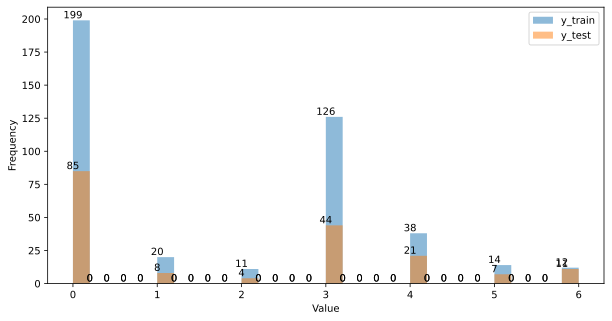

In [5]:
def plot_histogram(y1, y2, y1_label="y1", y2_label="y2"):
    plt.figure(figsize=(10, 5))
    counts1, bins1, patches1 = plt.hist(y1, bins=30, alpha=0.5, label=y1_label)
    counts2, bins2, patches2 = plt.hist(y2, bins=30, alpha=0.5, label=y2_label)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.legend(loc="upper right")

    # Annotate y1 histogram bars
    for count, bn, _patch in zip(counts1, bins1, patches1):
        plt.text(bn, count, str(int(count)), color="black", ha="center", va="bottom")

    # Annotate y2 histogram bars
    for count, bn, _patch in zip(counts2, bins2, patches2):
        plt.text(bn, count, str(int(count)), color="black", ha="center", va="bottom")

    plt.show()


plot_histogram(y_train, y_test, "y_train", "y_test")

# Accuracy of a classifier that only learns probability distribution

In [6]:
class_counts = np.bincount(y_train)
relative_frequencies = class_counts / len(y_train)

num_iterations = 1000
scores = []

for _ in range(num_iterations):
    # Sample instances according to the relative frequencies in y_train
    samples = np.random.choice(7, size=len(y_test), p=relative_frequencies)

    pred = torch.tensor(samples)
    labels = torch.tensor(y_test)
    correct = pred.eq(labels).sum().item()
    total = len(y_test)
    scores.append(int(correct) / total)

# Calculate the average score
average_score = sum(scores) / num_iterations
print(average_score)

0.3156444444444443


In [7]:
class MyDataset(Dataset):
    def __init__(self, data_list, scores_list, zx=False, max_num_of_circuits=100):
        super().__init__(".")
        self.data = []
        counts = {}

        for graphs, score in zip(data_list, scores_list):
            X = graphs[1] if zx else graphs[0]
            if X is None:
                continue
            y = torch.tensor(score)
            y[y == -1] = 0  # NOTE: score 0,1 might be easier to predict -> sigmoid
            label = y.argmax().item()
            counts[label] = counts.get(label, 0) + 1
            if counts[label] > max_num_of_circuits:
                continue
            X.y = y.float()
            self.data.append(X)
        return

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return []

    def len(self):
        return len(self.data)

    def get(self, idx):
        return self.data[idx]

    def process(self):
        pass

# Either use the ZX graph or the standard graph from qiskit
use_zx_graph = False

# Create the dataset
train_dataset = MyDataset(X_train, [scores_list[i] for i in indices_train], zx=use_zx_graph)
test_dataset = MyDataset(X_test, [scores_list[i] for i in indices_test], zx=use_zx_graph)

Processing...
Done!
Processing...
Done!


# GNN Classifier

In [11]:
clf = GNNClassifier(
    num_node_categories=43,  # distinct gate types (incl. 'id' and 'meas')
    num_edge_categories=2,  # wire features (control/target)
    output_dim=7,  # number of classes (devices)
    zx=use_zx_graph,
)

param_grid = [
    {
        "model": ["TransformerConv"],
        # --------------------------------
        "optimizer": ["adam"],
        "learning_rate": [1e-3],
        "batch_size": [16],
        "epochs": [50],
        # --------------------------------
        "node_embedding_dim": [None],
        "edge_embedding_dim": [None],
        "num_layers": [3],
        "hidden_dim": [4],
        "dropout": [0.],
        "batch_norm": [False],
        "activation": ["relu"],
        "readout": ["feat-attention"],
        "heads": [2],
        "concat": [True],
        "beta": [False],
        "bias": [True],
        "root_weight": [True],
    },
    {
        "model": ["GAT", "GCN"],
        # --------------------------------
        "optimizer": ["adam"],
        "learning_rate": [1e-3],
        "batch_size": [16],
        "epochs": [25],
        # --------------------------------
        "node_embedding_dim": [None],
        "edge_embedding_dim": [None],
        "num_layers": [3],
        "hidden_dim": [4, 8],
        "dropout": [0.],
        "batch_norm": [False],
        "activation": ["relu"],
        "readout": ["node-attention"],
        "jk": [None],
    },
]
with parallel_config(backend="threading", n_jobs=-1):
    clf = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1, verbose=3).fit(train_dataset)

y_pred = np.array(list(clf.predict(test_dataset)))
res, rel_scores = predictor.calc_performance_measures(scores_filtered, y_pred, y_test)
predictor.plot_eval_histogram(res, filename="RandomForestClassifier", color=color1)
rel_goodness = np.round(np.mean(rel_scores), 4)
rel_goodness_std = np.round(np.std(rel_scores), 4)
print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Rel Goodness: ", rel_goodness)
print("Rel Goodness Std: ", rel_goodness_std)
performance.append(("Random Forest", clf.best_score_, top3, max(res), rel_goodness, rel_goodness_std))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 3/3] END activation=relu, batch_norm=False, batch_size=16, dropout=0.0, edge_embedding_dim=None, epochs=25, hidden_dim=4, jk=None, learning_rate=0.001, model=GCN, node_embedding_dim=None, num_layers=3, optimizer=adam, readout=node-attention;, score=0.183 total time=  51.7s
[CV 1/3] END activation=relu, batch_norm=False, batch_size=16, dropout=0.0, edge_embedding_dim=None, epochs=25, hidden_dim=4, jk=None, learning_rate=0.001, model=GCN, node_embedding_dim=None, num_layers=3, optimizer=adam, readout=node-attention;, score=0.479 total time=  52.5s
[CV 2/3] END activation=relu, batch_norm=False, batch_size=16, dropout=0.0, edge_embedding_dim=None, epochs=25, hidden_dim=4, jk=None, learning_rate=0.001, model=GCN, node_embedding_dim=None, num_layers=3, optimizer=adam, readout=node-attention;, score=0.351 total time=  53.2s


In [10]:
clf.best_params_

{'activation': 'relu',
 'batch_norm': False,
 'batch_size': 16,
 'dropout': 0.0,
 'edge_embedding_dim': None,
 'epochs': 25,
 'hidden_dim': 8,
 'jk': None,
 'learning_rate': 0.001,
 'model': 'GCN',
 'node_embedding_dim': None,
 'num_layers': 3,
 'optimizer': 'adam',
 'readout': 'node-attention'}

# Data Preparation

In [ ]:
import numpy as np
from sklearn import svm, tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from mqt.predictor import ml

np.random.seed(10)

predictor = ml.Predictor()
figure_of_merit = "critical_depth"

training_data = predictor.get_prepared_training_data(figure_of_merit=figure_of_merit, save_non_zero_indices=True)

X_train = training_data.X_train
X_test = training_data.X_test
y_train = training_data.y_train
y_test = training_data.y_test
indices_train = training_data.indices_train
indices_test = training_data.indices_test
names_list = training_data.names_list
scores_list = training_data.scores_list

scores_filtered = [scores_list[i] for i in indices_test]
names_filtered = [names_list[i] for i in indices_test]

performance = []

In [ ]:
color1 = "#21918c"
color2 = "#440154"

In [ ]:
print(X_train)

In [ ]:
print(len(X_train), len(X_test))

# Random Forest

In [ ]:
clf = RandomForestClassifier(random_state=0)
tree_param = [
    {
        "n_estimators": [100, 200, 500],
        "max_depth": list(range(8, 30, 6)),
        "min_samples_split": list(range(2, 20, 6)),
        "min_samples_leaf": list(range(2, 20, 6)),
        "bootstrap": [True, False],
    },
]
clf = GridSearchCV(clf, tree_param, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res, rel_scores = predictor.calc_performance_measures(scores_filtered, y_pred, y_test)
predictor.plot_eval_histogram(res, filename="RandomForestClassifier", color=color1)
rel_goodness = np.round(np.mean(rel_scores), 4)
rel_goodness_std = np.round(np.std(rel_scores), 4)
print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Feature Importance: ", clf.best_estimator_.feature_importances_)
print("Rel Goodness: ", rel_goodness)
print("Rel Goodness Std: ", rel_goodness_std)
performance.append(("Random Forest", clf.best_score_, top3, max(res), rel_goodness, rel_goodness_std))

In [ ]:
predictor.plot_eval_all_detailed_compact_normed(
    names_filtered, scores_filtered, y_pred, y_test, color_all=color1, color_pred=color2
)

In [ ]:
clf.best_estimator_.get_params()

### Feature Importances

In [ ]:
path = ml.helper.get_path_trained_model(figure_of_merit, return_non_zero_indices=True)
non_zero_indices = np.load(str(path), allow_pickle=True)

openqasm_qc_list = ml.helper.get_openqasm_gates()
feature_names = [openqasm_qc_list[i] for i in range(len(openqasm_qc_list))]
feature_names.append("num qubits")
feature_names.append("depth")
feature_names.append("prog. comm.")
feature_names.append("crit. dept")
feature_names.append("entang. ratio")
feature_names.append("parallelism")
feature_names.append("liveness")
feature_names = [feature_names[i] for i in non_zero_indices]

importances = clf.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.best_estimator_.estimators_], axis=0)

idx = np.argsort(-importances)

plt.figure(figsize=(8, 6))
plt.bar(np.array(feature_names)[idx], np.array(importances)[idx], color=color1, width=0.9)
plt.errorbar(
    np.array(feature_names)[idx],
    np.array(importances)[idx],
    np.array(std)[idx],
    fmt="o",
    color=color2,
)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel("Relative feature importance", fontsize=18)
plt.tight_layout()
plt.savefig("results/feature_importances.pdf")
plt.show()

#### Check the relative importances per feature

In [ ]:
summary = zip(np.array(feature_names)[idx], np.array(importances)[idx])
for feature, importance in list(summary):
    print(feature, np.round(importance, 3))

# GradientBoostingClassifier

In [ ]:
clf = GradientBoostingClassifier()

param_grid = {
    "learning_rate": [0.01, 0.1, 1],
}

clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))

res, rel_scores = predictor.calc_performance_measures(scores_filtered, y_pred, y_test)
predictor.plot_eval_histogram(res, filename="GradientBoostingClassifier", color=color1)
rel_goodness = np.round(np.mean(rel_scores), 4)
rel_goodness_std = np.round(np.std(rel_scores), 4)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Rel Goodness: ", rel_goodness)
print("Rel Goodness Std: ", rel_goodness_std)
performance.append(("Gradient Boosting", clf.best_score_, top3, max(res), rel_goodness, rel_goodness_std))

# Decision Tree Classifier

In [ ]:
clf = tree.DecisionTreeClassifier(random_state=5)

tree_param = [
    {
        "criterion": ["entropy", "gini"],
        "max_depth": list(range(1, 15, 1)),
        "min_samples_split": list(range(2, 20, 4)),
        "min_samples_leaf": list(range(2, 20, 4)),
        "max_leaf_nodes": list(range(2, 200, 40)),
        "max_features": list(range(1, len(non_zero_indices), 10)),
    },
]
clf = GridSearchCV(clf, tree_param, cv=5, n_jobs=8).fit(X_train, y_train)
y_pred = np.array(list(clf.predict(X_test)))
res, rel_scores = predictor.calc_performance_measures(scores_filtered, y_pred, y_test)
predictor.plot_eval_histogram(res, filename="DecisionTreeClassifier", color=color1)
rel_goodness = np.round(np.mean(rel_scores), 4)
rel_goodness_std = np.round(np.std(rel_scores), 4)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Rel Goodness: ", rel_goodness)
print("Rel Goodness Std: ", rel_goodness_std)
print("Feature Importance: ", clf.best_estimator_.feature_importances_)
performance.append(("Decision Tree", clf.best_score_, top3, max(res), rel_goodness, rel_goodness_std))

# Nearest Neighbor

In [ ]:
clf = KNeighborsClassifier()
param_grid = {"n_neighbors": range(1, 10, 1)}
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res, rel_scores = predictor.calc_performance_measures(scores_filtered, y_pred, y_test)
predictor.plot_eval_histogram(res, filename="KNeighborsClassifier", color=color1)
rel_goodness = np.round(np.mean(rel_scores), 4)
rel_goodness_std = np.round(np.std(rel_scores), 4)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Rel Goodness: ", rel_goodness)
print("Rel Goodness Std: ", rel_goodness_std)
performance.append(("Nearest Neighbor", clf.best_score_, top3, max(res), rel_goodness, rel_goodness_std))

# MLPClassifier

In [ ]:
clf = MLPClassifier(max_iter=1000)

param_grid = {
    "hidden_layer_sizes": [(50, 50, 50), (50, 100, 50), (100,)],
    "activation": ["tanh", "relu"],
    "solver": ["sgd", "adam"],
    "alpha": [0.0001, 0.05],
    "learning_rate": ["constant", "adaptive"],
}

clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res, rel_scores = predictor.calc_performance_measures(scores_filtered, y_pred, y_test)
predictor.plot_eval_histogram(res, filename="MLPClassifier", color=color1)
rel_goodness = np.round(np.mean(rel_scores), 4)
rel_goodness_std = np.round(np.std(rel_scores), 4)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Rel Goodness: ", rel_goodness)
print("Rel Goodness Std: ", rel_goodness_std)
performance.append(("Multilayer Perceptron", clf.best_score_, top3, max(res), rel_goodness, rel_goodness_std))

# SVM

In [ ]:
clf = svm.SVC()
param_grid = {"C": [0.1, 1, 10], "gamma": [1, 0.1, 0.01], "kernel": ["rbf", "sigmoid"]}
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res, rel_scores = predictor.calc_performance_measures(scores_filtered, y_pred, y_test)
predictor.plot_eval_histogram(res, filename="SVM", color=color1)
rel_goodness = np.round(np.mean(rel_scores), 4)
rel_goodness_std = np.round(np.std(rel_scores), 4)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Rel Goodness: ", rel_goodness)
print("Rel Goodness Std: ", rel_goodness_std)
performance.append(("Support Vector Machine", clf.best_score_, top3, max(res), rel_goodness, rel_goodness_std))

# Naive Bayes

In [ ]:
clf = GaussianNB()
param_grid = {"var_smoothing": np.logspace(0, -9, num=100)}
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res, rel_scores = predictor.calc_performance_measures(scores_filtered, y_pred, y_test)
predictor.plot_eval_histogram(res, filename="GaussianNB", color=color1)
rel_goodness = np.round(np.mean(rel_scores), 4)
rel_goodness_std = np.round(np.std(rel_scores), 4)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Rel Goodness: ", rel_goodness)
print("Rel Goodness Std: ", rel_goodness_std)
performance.append(("Naive Bayes", clf.best_score_, top3, max(res), rel_goodness, rel_goodness_std))

# Save Performance Results

In [ ]:
print(performance)
from pathlib import Path

file = Path("results/performances_" + figure_of_merit + ".csv")
with file.open("w") as f:
    f.write("Classifier, Accuracy, Top3, Worst Rank, Eval. Score Diff., Std\n")
    for sublist in performance:
        line = f"{sublist[0]}, {sublist[1]}, {sublist[2]}, {sublist[3]}, {sublist[4]}, {sublist[5]} \n"
        f.write(line)